# Classification des cellules sanguines cancéreuses (PyTorch).

## 1️⃣ Importation et préparation des données

### Imports : 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import random
import os
import cv2
from typing import Counter

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix

import torchviz
from torchview import draw_graph
import time



### Charger les images du dataset et vérifier leurs extensions (jpeg, jpg, bmp, png). Supprimer celles qui ne correspondent pas.

In [2]:
dataset_path = Path("../data/Blood_Cells_Cancer/")

valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

images = []
labels = []

In [3]:
problem_files = 0

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            if file_name.lower().endswith(valid_extensions):
                
                try:
                    img = cv2.imread(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(class_name)
                    else:
                        problem_files += 1
                        print(f"Impossible de lire l'image : {file_path}")
                        # supprimer si le file ne s'ouvre pas
                        try:
                            os.remove(file_path)
                        except Exception as e:
                            print(f"Erreur lors de la suppression de {file_path} : {e}")
                        
                except Exception as e :
                    print(f"Erreur lors du chargement de {file_path} : {e}")
                    
            else:
                problem_files += 1
                print(f"Extension non valide, fichier {file_path}")
                # supprimer si le fichier n'a pas l'extension valide
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Erreur lors de la suppression de {file_path} : {e}")
                
        

In [4]:
print(f"Nombre total d'images valides : {len(images)}")
print(f"Nombre de fichiers problématiques : {problem_files}")

Nombre total d'images valides : 3242
Nombre de fichiers problématiques : 0


## 2️⃣ Exploration et visualisation du dataset

### Explorer les classes du dataset (les noms des dossiers représentent les classes).

In [5]:
# Explorer les classes
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print(f"Les classes sont : {classes}")

Les classes sont : ['Benign', 'early Pre-B', 'Pre-B', 'Pro-B']


### Montrez un nombre d’échantillons dans chaque classe par countplot.

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\443092441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, order=pd.Series(labels).value_counts().index, palette='viridis')


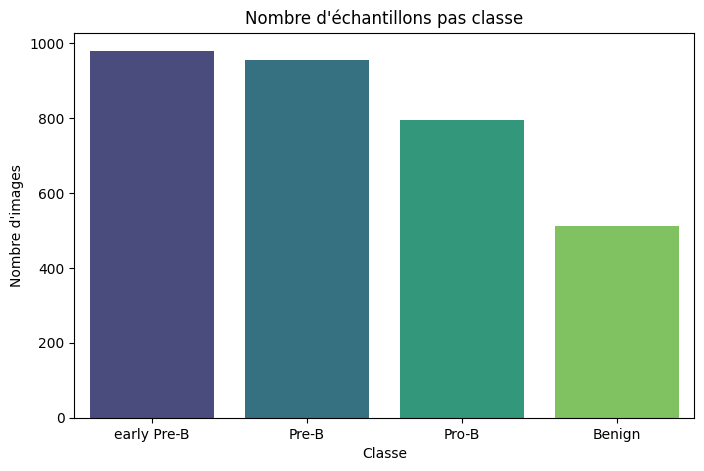

In [6]:
# affichier les nombres des classes avec un plot
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, order=pd.Series(labels).value_counts().index, palette='viridis')
plt.title("Nombre d'échantillons pas classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

In [7]:
# Nombre des images par classe : 

class_counts = Counter(np.array(labels))
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}' : {count} images")

Classe 'Benign' : 512 images
Classe 'early Pre-B' : 979 images
Classe 'Pre-B' : 955 images
Classe 'Pro-B' : 796 images


### Montrer un échantillon d’images pour chaque classe.

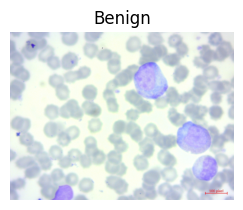

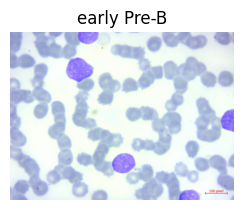

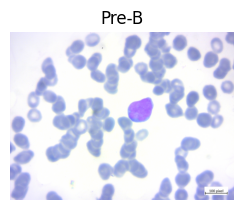

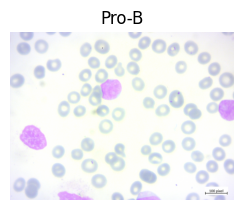

In [8]:
# Benign exp. image

img1_path = '../data/Blood_Cells_Cancer/Benign/Snap_027.jpg'

image = cv2.imread(img1_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Benign")
plt.axis('off')
plt.show()

# early Pre-B exp. image

img2_path = '../data/Blood_Cells_Cancer/early Pre-B/Sap_148 (51).jpg'

image = cv2.imread(img2_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("early Pre-B")
plt.axis('off')
plt.show()


# Pre-B exp. image

img3_path = '../data/Blood_Cells_Cancer/Pre-B/Snap_009.jpg'

image = cv2.imread(img3_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Pre-B")
plt.axis('off')
plt.show()

# early Pro-B exp. image

img4_path = '../data/Blood_Cells_Cancer/Pro-B/Snap_013.jpg'

image = cv2.imread(img4_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Pro-B")
plt.axis('off')
plt.show()

## 3️⃣ Division du dataset

### Diviser les images en trois ensembles (dossiers) : Train, Validation et Test, selon la répartition suivante : 70 % pour l’entraînement, 15 % pour la validation et 15 % pour le test.

In [9]:
# mixer dataset 
data_compined = list(zip(images, labels))
random.seed(42)
random.shuffle(data_compined)
images, labels = zip(*data_compined)
images = list(images)
labels = list(labels)

In [10]:
import splitfolders
splitfolders.ratio(dataset_path, output="../data/data_diviser", seed=42, ratio=(.7, .15, .15))


### Compter les images dans chaque dossier.

In [11]:
base_dir = "../data/data_diviser"
sets = ['train', 'val', 'test']

data_counts = []

for set_name in sets:
    set_path = os.path.join(base_dir, set_name)
    total_images = 0
    print(f"\n ✅ {set_name}")
    
    for class_name in os.listdir(set_path):
        class_path = os.path.join(set_path, class_name)
        
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            total_images += count
            data_counts.append([set_name, class_name, count])
            print(f"------> Total images dans {class_name} : {count}")
    print(f"=> Total images dans {set_name} : {total_images}")


 ✅ train
------> Total images dans Benign : 358
------> Total images dans early Pre-B : 685
------> Total images dans Pre-B : 668
------> Total images dans Pro-B : 557
=> Total images dans train : 2268

 ✅ val
------> Total images dans Benign : 76
------> Total images dans early Pre-B : 146
------> Total images dans Pre-B : 143
------> Total images dans Pro-B : 119
=> Total images dans val : 484

 ✅ test
------> Total images dans Benign : 78
------> Total images dans early Pre-B : 148
------> Total images dans Pre-B : 144
------> Total images dans Pro-B : 120
=> Total images dans test : 490


In [12]:
df_counts = pd.DataFrame(data_counts, columns=["Dataset", "Classe", "Nombre d'images"])
# df_counts

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


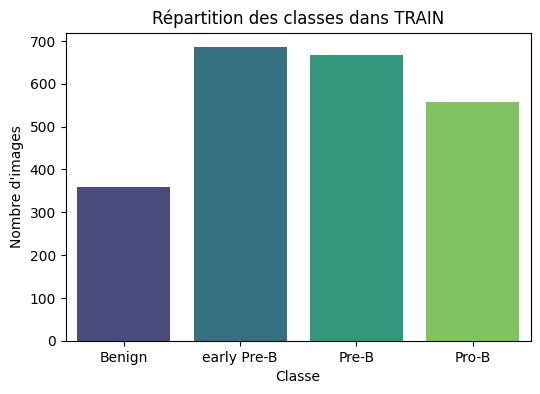

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


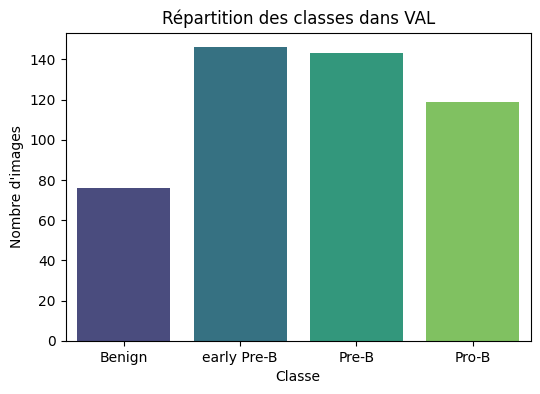

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


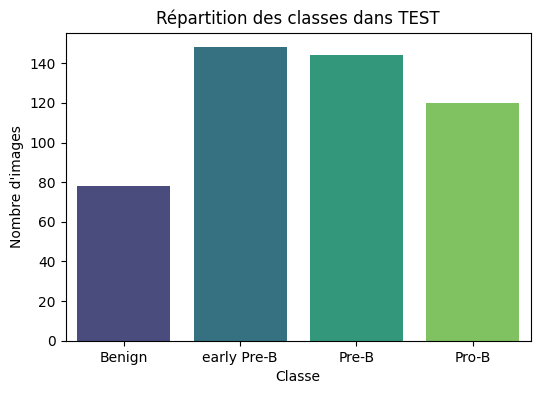

In [13]:
# afficher avec des graphes le nombres des images de cahque classe dans train, test,val

for set_name in sets:
    plt.figure(figsize=(6, 4))
    subset = df_counts[df_counts["Dataset"] == set_name]
    sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")
    plt.title(f"Répartition des classes dans {set_name.upper()}")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.show()

## 4️⃣ Augmentation des données

* Appliquer des transformations telles que "blur, noise et flip" sur les données d’entraînement afin d’équilibrer les classes et augmenter le nombre d’images.


In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
])

In [15]:
from torchvision import transforms
from PIL import Image
import os
import random
from collections import Counter
import shutil

# Dossier source et destination
train_dir = "../data/data_diviser/train"
balanced_dir = "../data/data_diviser/train_augmented"

# Créer le dossier de sortie
os.makedirs(balanced_dir, exist_ok=True)

# Extensions valides
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# --- 🔁 Transformations d’augmentation ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(25),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Pour revenir à une image avant sauvegarde
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)
to_pil = transforms.ToPILImage()

# --- 📊 Lire la distribution initiale ---
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        n_images = len([f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)])
        class_counts[class_name] = n_images

print("📊 Répartition initiale des classes :")
for k, v in class_counts.items():
    print(f" - {k} : {v} images")

# --- 🔝 Trouver la classe majoritaire ---
max_count = max(class_counts.values())
print(f"\n➡️ Classe majoritaire : {max_count} images")

# --- 📂 Copier les images originales ---
for class_name in class_counts.keys():
    src = os.path.join(train_dir, class_name)
    dst = os.path.join(balanced_dir, class_name)
    os.makedirs(dst, exist_ok=True)
    
    for file_name in os.listdir(src):
        if not file_name.lower().endswith(valid_extensions):
            continue
        src_file = os.path.join(src, file_name)
        dst_file = os.path.join(dst, file_name)
        shutil.copy2(src_file, dst_file)

# --- 🔁 Appliquer des augmentations pour équilibrer ---
for class_name, count in class_counts.items():
    class_src = os.path.join(train_dir, class_name)
    class_dst = os.path.join(balanced_dir, class_name)

    if count < max_count:
        print(f"\n🔁 Augmentation de la classe '{class_name}' ({count} → {max_count}) ...")
        needed = max_count - count

        image_files = [f for f in os.listdir(class_src) if f.lower().endswith(valid_extensions)]
        random.seed(42)

        for i in range(needed):
            file_name = random.choice(image_files)
            file_path = os.path.join(class_src, file_name)

            try:
                img = Image.open(file_path).convert("RGB")
                aug_tensor = train_transforms(img)
                aug_tensor = unnormalize(aug_tensor)
                aug_img = to_pil(aug_tensor)

                new_name = f"{os.path.splitext(file_name)[0]}_aug{i+1}.jpg"
                aug_img.save(os.path.join(class_dst, new_name))
            except Exception as e:
                print(f"⚠️ Erreur lors de l’augmentation de {file_name} : {e}")

print("\n✅ Jeu de données équilibré créé dans : 'train_balanced'")


📊 Répartition initiale des classes :
 - Benign : 358 images
 - early Pre-B : 685 images
 - Pre-B : 668 images
 - Pro-B : 557 images

➡️ Classe majoritaire : 685 images

🔁 Augmentation de la classe 'Benign' (358 → 685) ...

🔁 Augmentation de la classe 'Pre-B' (668 → 685) ...

🔁 Augmentation de la classe 'Pro-B' (557 → 685) ...

✅ Jeu de données équilibré créé dans : 'train_balanced'


In [16]:

sets_augmented = ['train', 'train_augmented']
print(sets_augmented)
data_counts = []

for set_name in sets_augmented:
    set_path = os.path.join(base_dir, set_name)
    total_images = 0
    print(f"\n ✅ {set_name}")
    
    for class_name in os.listdir(set_path):
        class_path = os.path.join(set_path, class_name)
        
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            total_images += count
            data_counts.append([set_name, class_name, count])
            print(f"------> Total images dans {class_name} : {count}")
    print(f"=> Total images dans {set_name} : {total_images}")

['train', 'train_augmented']

 ✅ train
------> Total images dans Benign : 358
------> Total images dans early Pre-B : 685
------> Total images dans Pre-B : 668
------> Total images dans Pro-B : 557
=> Total images dans train : 2268

 ✅ train_augmented
------> Total images dans Benign : 685
------> Total images dans early Pre-B : 685
------> Total images dans Pre-B : 685
------> Total images dans Pro-B : 685
=> Total images dans train_augmented : 2740


In [17]:
df_counts = pd.DataFrame(data_counts, columns=["Dataset", "Classe", "Nombre d'images"])
# df_counts

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\3135707026.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


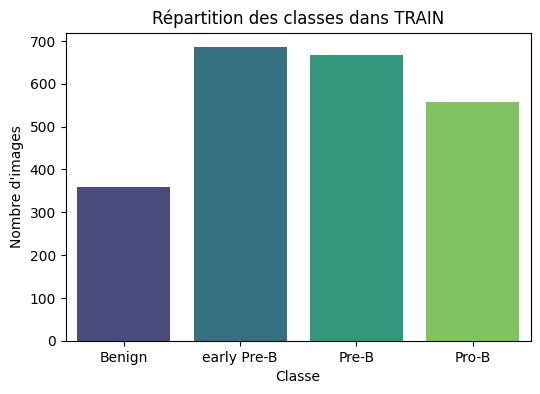

C:\Users\ramas\AppData\Local\Temp\ipykernel_26224\3135707026.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


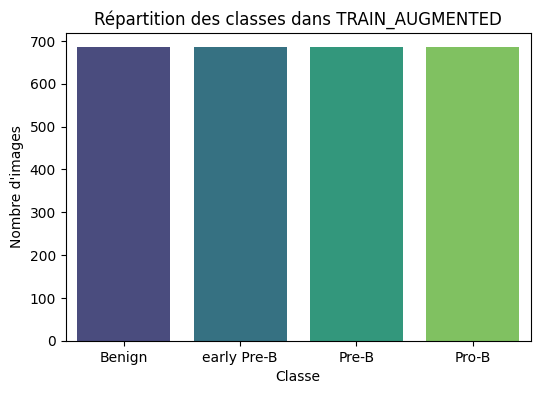

In [18]:
# afficher avec des graphes le nombres des images de cahque classe dans train, train_augmented

for set_name in sets_augmented:
    plt.figure(figsize=(6, 4))
    subset = df_counts[df_counts["Dataset"] == set_name]
    sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")
    plt.title(f"Répartition des classes dans {set_name.upper()}")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.show()

* Utiliser les Transforms de PyTorch dans le Dataset(ImageFolder) pour redimensionner les images, les convertir en tenseurs et les normaliser


In [19]:
# train_data = datasets.ImageFolder('../data/data_diviser/train_augmented', transform=train_transforms)
train_data = datasets.ImageFolder('../data/data_diviser/train_augmented', transform=train_transforms)
val_data = datasets.ImageFolder('../data/data_diviser/val', transform=val_transforms)
test_data = datasets.ImageFolder('../data/data_diviser/test', transform=val_transforms)


## 5️⃣ Chargement des données

In [20]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

* Voir des exemples des images transformées


 Train  : 


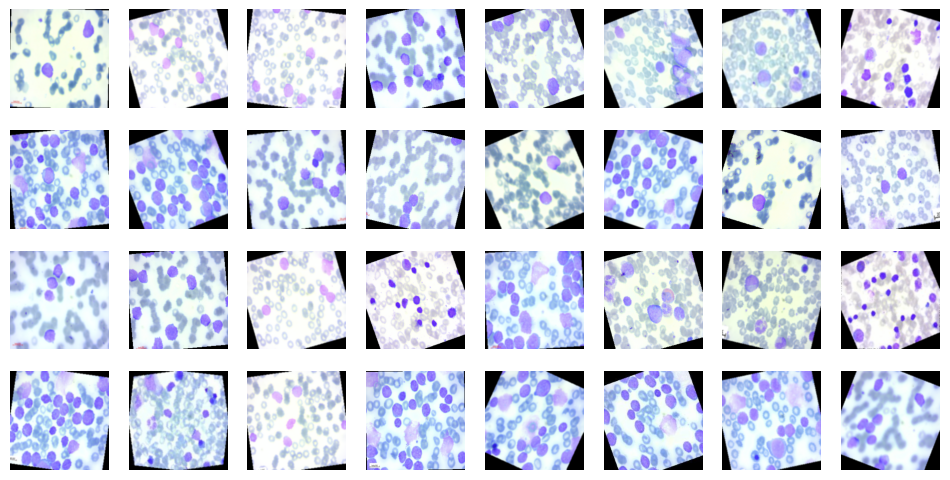


 Test  : 


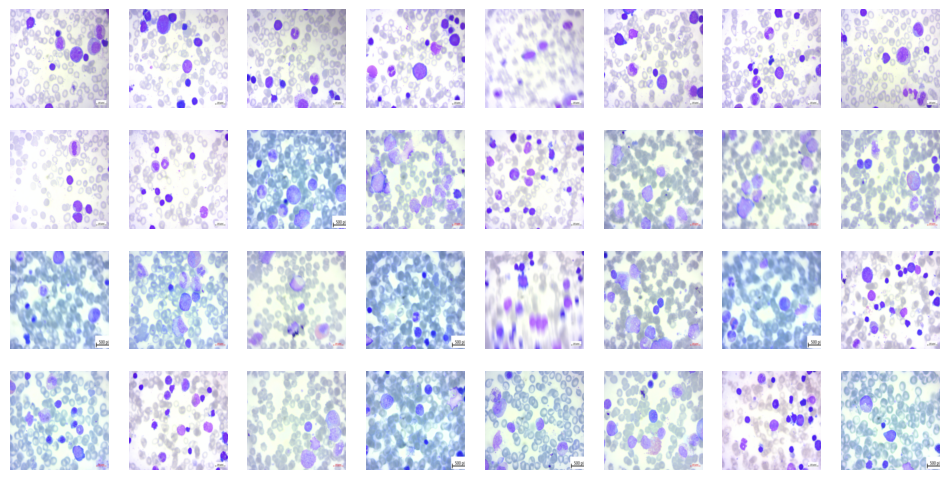


 Val  : 


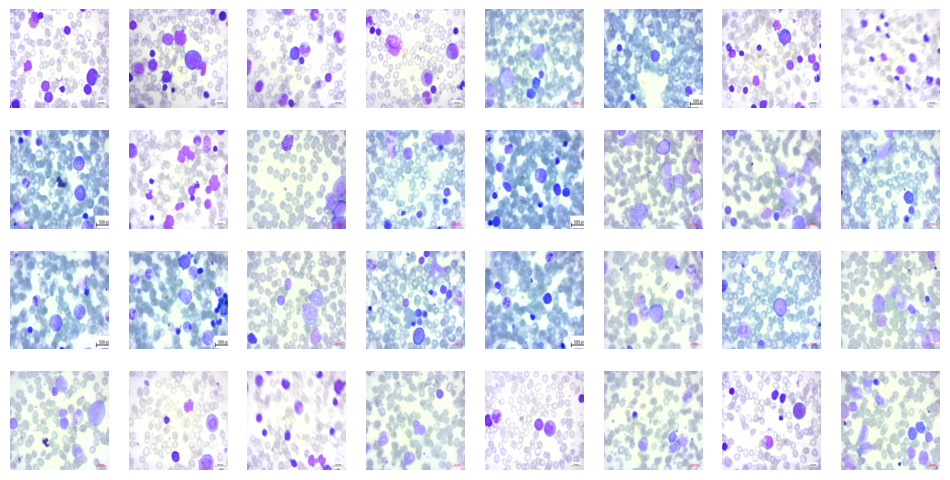

In [21]:
def img_show_batch(dataloder, title):
    images, labels = next(iter(dataloder))
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) +  [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
    print("\n",title, " : ")
    plt.show()
    
img_show_batch(train_loader, title="Train")
img_show_batch(test_loader, title="Test")
img_show_batch(val_loader, title="Val")

## 6️⃣ Construction du modèle

### Utiliser le modèle pré-entraîné GoogLeNet et remplacer sa partie fully connected (FC) par un réseau séquentiel entièrement connecté, adapté à la tâche spécifique de classification.

* Charger le modèle pré-entrainé GoogleNet : 

In [22]:
model = models.googlenet(pretrained=False, aux_logits=False)

c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [23]:
# Avec Modifier le FC

x = torch.randn(1, 3, 224, 224)
y = model(x)
torchviz.make_dot(y, params=dict(model.named_parameters())).render("../googlenet_avant", format="png")

'..\\googlenet_avant.png'

In [24]:
model.fc

Linear(in_features=1024, out_features=1000, bias=True)

* Remplacer la partie fully connected (FC) par un réseau séquentiel adapté à la tâche

In [25]:
nbr_classes = len(classes)

model.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(in_features=512 , out_features=nbr_classes)
)



In [26]:
model.fc

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

In [27]:
# Après la modification de FC

x = torch.randn(1, 3, 224, 224)
y = model(x)
torchviz.make_dot(y, params=dict(model.named_parameters())).render("../googlenet_apres", format="png")

'..\\googlenet_apres.png'

## 7️⃣ Entraînement et évaluation du modèle : 

* Déterminer le learning rate, la fonction de perte et l’optimiseur

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model = model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
learning_rate = 0.0001
loss_funct = nn.CrossEntropyLoss()
optimiseur = optim.Adam(model.fc.parameters(), lr=learning_rate)

* Entraîner le modèle

In [30]:
train_loss = []
train_accuracy = []
val_accuracy = []

In [31]:
nbr_epochs = 30



print(f"▶️ Start Entraînement ⌛ ...")
start_time = time.time()
for epoch in range(nbr_epochs):
    
    print(f"\nStart Epoch [{epoch+1}/{nbr_epochs}] : ")
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimiseur.zero_grad()
        outputs = model(images)
        loss = loss_funct(outputs, labels)
        loss.backward()
        optimiseur.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_acc = correct / total
    val_acc = 0
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
        val_acc = correct_val / total_val
        loss_train = running_loss/len(train_loader)
        
        val_accuracy.append(val_acc)
        train_accuracy.append(train_acc)
        train_loss.append(loss_train)
        
    print(f"    Epoch [{epoch+1}/{nbr_epochs}] - Loss: {loss_train:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
end_time = time.time()

training_time = end_time - start_time
print(f"✅ Entrînement terminé !")
print(f"Temps total :{training_time/60:.2f} minutes")


▶️ Start Entraînement ⌛ ...

Start Epoch [1/30] : 
    Epoch [1/30] - Loss: 1.2948 | Train Acc: 0.4500 | Val Acc: 0.6674

Start Epoch [2/30] : 
    Epoch [2/30] - Loss: 1.1147 | Train Acc: 0.5945 | Val Acc: 0.7583

Start Epoch [3/30] : 
    Epoch [3/30] - Loss: 0.9930 | Train Acc: 0.6241 | Val Acc: 0.7438

Start Epoch [4/30] : 
    Epoch [4/30] - Loss: 0.9261 | Train Acc: 0.6391 | Val Acc: 0.7541

Start Epoch [5/30] : 
    Epoch [5/30] - Loss: 0.8679 | Train Acc: 0.6803 | Val Acc: 0.7562

Start Epoch [6/30] : 
    Epoch [6/30] - Loss: 0.8220 | Train Acc: 0.6781 | Val Acc: 0.7789

Start Epoch [7/30] : 
    Epoch [7/30] - Loss: 0.8022 | Train Acc: 0.6971 | Val Acc: 0.7810

Start Epoch [8/30] : 
    Epoch [8/30] - Loss: 0.7656 | Train Acc: 0.7095 | Val Acc: 0.8058

Start Epoch [9/30] : 
    Epoch [9/30] - Loss: 0.7600 | Train Acc: 0.7080 | Val Acc: 0.7831

Start Epoch [10/30] : 
    Epoch [10/30] - Loss: 0.7202 | Train Acc: 0.7230 | Val Acc: 0.8079

Start Epoch [11/30] : 
    Epoch [11/30

* Évaluer et tester le modèle après l’entraînement afin de mesurer ses performances, sa précision, et sa capacité à généraliser sur des données inédites.

In [40]:
len(train_loss)

30

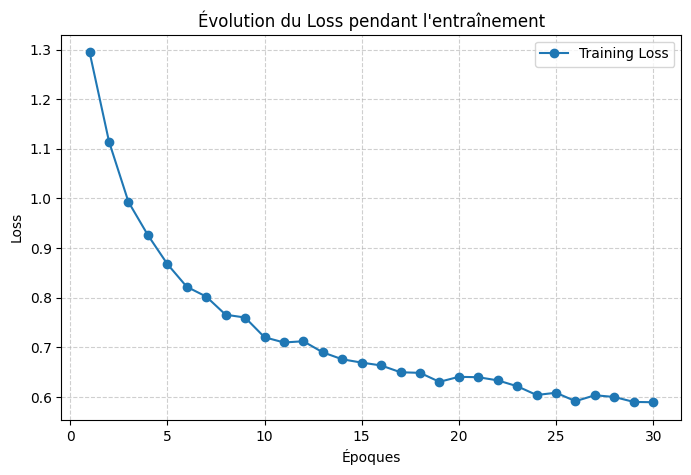

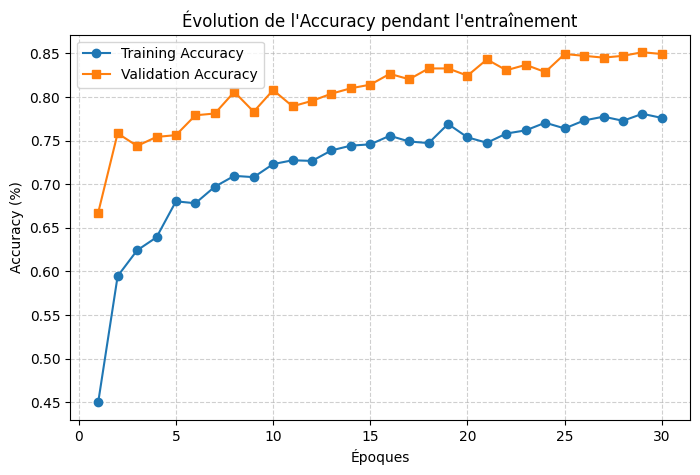

In [33]:
import matplotlib.pyplot as plt

nbr_epochs = 30
# Époques
epochs = list(range(1, nbr_epochs+1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.title("Évolution du Loss pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, marker='s', label='Validation Accuracy')
plt.title("Évolution de l'Accuracy pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


* rapport de classification : 

In [41]:
model.eval()

# test
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_funct(outputs, labels)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)

        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
        
avg_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f"Test Loss Moyenne : {avg_loss:.4f} ")
print(f"Test Accuracy : {accuracy:.2f}")
        
        
        

Test Loss Moyenne : 0.4114 
Test Accuracy : 0.85


In [42]:
print("\n Rapport de classification : ")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))


 Rapport de classification : 
              precision    recall  f1-score   support

      Benign       0.84      0.46      0.60        78
       Pre-B       0.95      0.88      0.91       144
       Pro-B       0.89      0.96      0.92       120
 early Pre-B       0.75      0.93      0.83       148

    accuracy                           0.85       490
   macro avg       0.86      0.81      0.82       490
weighted avg       0.86      0.85      0.84       490



* matrice de confusion : 

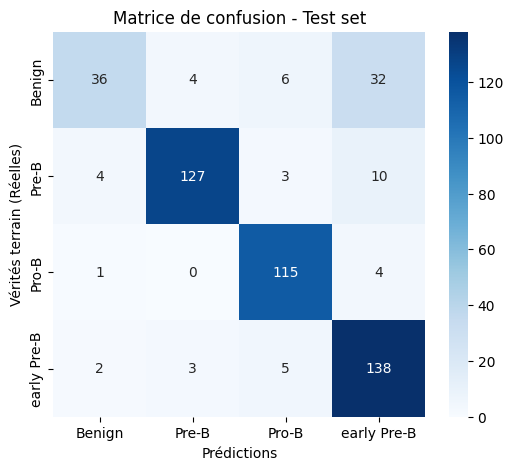

In [43]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes,
            yticklabels=test_data.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain (Réelles)")
plt.title("Matrice de confusion - Test set")
plt.show()


* Sauvegarder le modèle entraîné

In [45]:
torch.save(model.state_dict(), "../models/blood_cells_googlenet_model.pth")
print("✅ Modèle sauvegardé : blood_cells_googlenet.model.pth")

✅ Modèle sauvegardé : blood_cells_googlenet.model.pth


* tester le modèle

In [46]:
print(train_data.classes)

['Benign', 'Pre-B', 'Pro-B', 'early Pre-B']


In [49]:
img = Image.open("../data/data_diviser/test/Pre-B/Snap_044.jpg").convert("RGB")
input_tensor = val_transforms(img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)
print("Classe prédite :", train_data.classes[pred.item()])


Classe prédite : Pre-B
